This notebook is based and inspired by the following gits:

https://matteoacrossi.github.io/oqs-jupyterbook
and 

https://github.com/matteoacrossi/ibmq_open_quantum_systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
import copy

In [2]:
#You might need to install QisKit
#!pip install --upograde qiskit

In [3]:
# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.verification.tomography import StateTomographyFitter

#Visulalization
from qiskit.visualization import plot_bloch_vector
%matplotlib inline

# Let's start with bit-flip channel

In [4]:
sz  = np.array([[1,0],[0,-1]])
sx  = np.array([[0,1],[1,0]])
sy  = np.array([[0,-1j],[1j,0]])
id2 = np.array([[1,0],[0,1]])

sp = np.array([[0,1],[0,0]])
sm = np.array([[0,0],[1,0]])

In [5]:
def btFlip(x,p):
    res = (1-p)*x+p*multi_dot([sx,x,sx])
    return res

In [6]:
p_values = np.linspace(0, 1, 15)
print(p_values)

[0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]


In [7]:
rho = np.zeros((len(p_values),2,2), dtype=complex)
init=np.array([[1,0],[0,0]],dtype=complex)

for x in range(len(p_values)):
    rho[x] = btFlip(init, p_values[x])

In [8]:
def bit_flip_channel(q, p, system, ancillae):
    dc = QuantumCircuit(q)
   
    theta = np.arccos(1-2*p) #0.5 ?
    
    dc.ry(theta, q[ancillae[0]])
    
    # Prepare q[1] in a maximally mixed state by entangling it with q[0]
    dc.cx(q[ancillae[0]], q[system])
    return dc

In [9]:
# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')
vector_backend = Aer.get_backend('statevector_simulator')

SHOTS = 8192

# We create the quantum circuit
q = QuantumRegister(2, name='q')
c = ClassicalRegister(1, name='c')

# Index of the system qubit
system = 0

# Indices of the ancillary qubits
ancillae = [1]

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q) # just |0> in this case

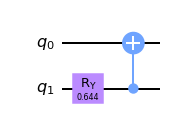

In [10]:
(prepare_state + bit_flip_channel(q, 0.1, system, ancillae)).draw(output='mpl')

In [11]:
# We append the measurements for the tomography
tomo_circuits = []
for p in p_values:
    circ = prepare_state + bit_flip_channel(q, p, system, ancillae)
    tomo_circuits += state_tomography_circuits(circ, q[system])

In [12]:
len(tomo_circuits)

45

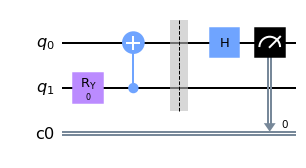

In [13]:
tomo_circuits[0].draw(output='mpl')

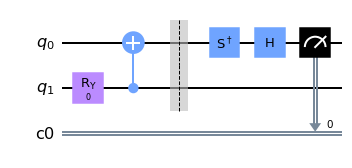

In [14]:
tomo_circuits[1].draw(output='mpl')

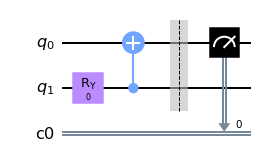

In [15]:
tomo_circuits[2].draw(output='mpl')

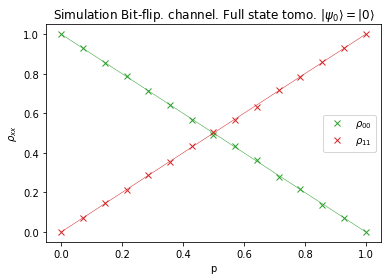

In [16]:
job = execute(tomo_circuits, backend=simulator, shots = SHOTS)

rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, p) in enumerate(p_values):
    test_result = copy.deepcopy(job.result())
    test_result.results = test_result.results[3*i:3*i+3]
    tomo_fitter = StateTomographyFitter(test_result, tomo_circuits[3*i:3*i+3])
    rhos[:,:,i] = tomo_fitter.fit()

# Simulated results
plt.plot(p_values, np.real(rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

# Theoretical prediction

plt.plot(p_values, np.real(rho[:,0,0]), "C2", linewidth=.5)
plt.plot(p_values, np.real(rho[:,1,1]), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("Simulation Bit-flip. channel. Full state tomo. $|\\psi_0\\rangle = |0\\rangle$");

In [17]:
def BlochVec(x):
    X = np.real(np.trace(sx.dot(x)))
    Y = np.real(np.trace(sy.dot(x)))
    Z = np.real(np.trace(sz.dot(x)))
    return np.array([X,Y,Z])

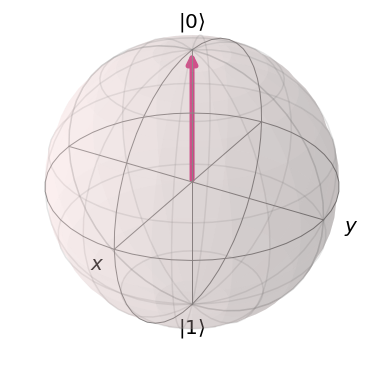

In [18]:
plot_bloch_vector(BlochVec(rhos[:,:,0]))

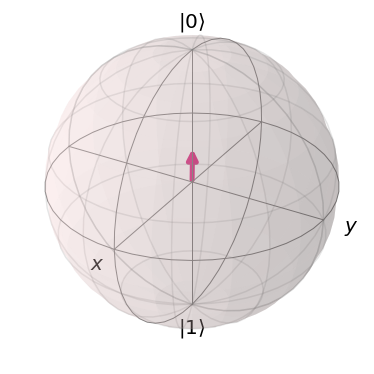

In [19]:
plot_bloch_vector(BlochVec(rhos[:,:,5]))

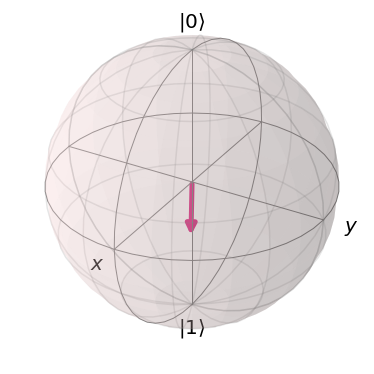

In [20]:
plot_bloch_vector(BlochVec(rhos[:,:,10]))

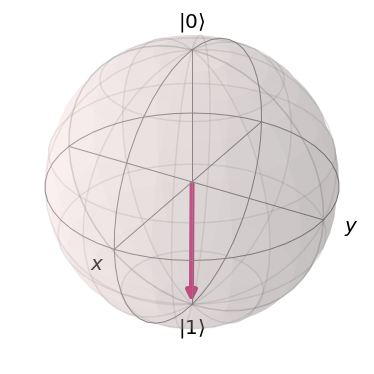

In [21]:
plot_bloch_vector(BlochVec(rhos[:,:,14]))

# Depolarizing channel

In [22]:
def Depol(x,p):
    res = (1-3*p/4)*x+(p/4)*multi_dot([sx,x,sx])+(p/4)*multi_dot([sy,x,sy])+(p/4)*multi_dot([sz,x,sz])
    return res

In [23]:
initPsi = np.array([np.cos(np.pi/8),np.exp(1j*np.pi/4)*np.sin(np.pi/8)])
init = np.outer(initPsi,np.conj(initPsi.T))

print(init)

[[0.85355339+0.j   0.25      -0.25j]
 [0.25      +0.25j 0.14644661+0.j  ]]


In [24]:
rho = np.zeros((len(p_values),2,2), dtype=complex)

for x in range(len(p_values)):
    rho[x] = Depol(init, p_values[x])

In [25]:
def depolarizing_channel(q, p, system, ancillae):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]

    Args:
        q (QuantumRegister): the register to use for the circuit
        p (float): the probability for the channel between 0 and 1
        system (int): index of the system qubit
        ancillae (list): list of indices for the ancillary qubits
        
    Returns:
        A QuantumCircuit object
    """
    dc = QuantumCircuit(q)
   
    theta = 1/2 * np.arccos(1-2*p)
    
    dc.ry(theta, q[ancillae[0]])
    dc.ry(theta, q[ancillae[1]])
    dc.ry(theta, q[ancillae[2]])

    # Prepare q[1] in a maximally mixed state by entangling it with q[0]
    dc.cx(q[ancillae[0]], q[system])
    dc.cy(q[ancillae[1]], q[system])
    dc.cz(q[ancillae[2]], q[system])
    return dc

In [26]:
# The values for p
p_values = np.linspace(0, 1, 15)

# We create the quantum circuit
q = QuantumRegister(4, name='q')
c = ClassicalRegister(1, name='c')

# Index of the system qubit
system = 0

# Indices of the ancillary qubits
ancillae = [1, 2, 3]

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u(np.pi/4, np.pi/4, 0, q[system])   

# We append the measurements for the tomography
tomo_circuits = []
for p in p_values:
    circ = prepare_state + depolarizing_channel(q, p, system, ancillae)
    tomo_circuits += state_tomography_circuits(circ, q[system])

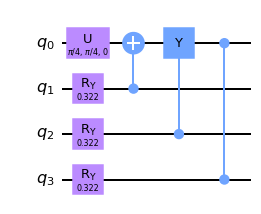

In [27]:
(prepare_state + depolarizing_channel(q, 0.1, system, ancillae)).draw(output='mpl')

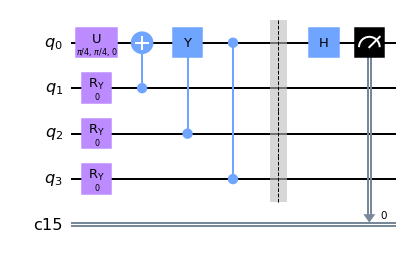

In [28]:
tomo_circuits[0].draw(output='mpl')

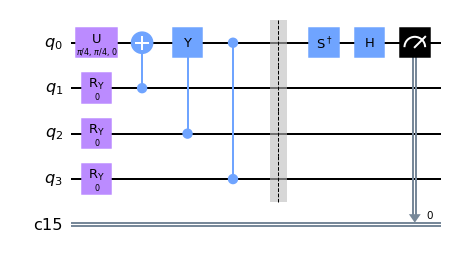

In [29]:
tomo_circuits[1].draw(output='mpl')

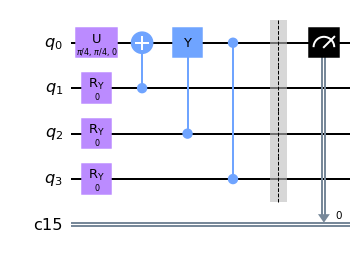

In [30]:
tomo_circuits[2].draw(output='mpl')

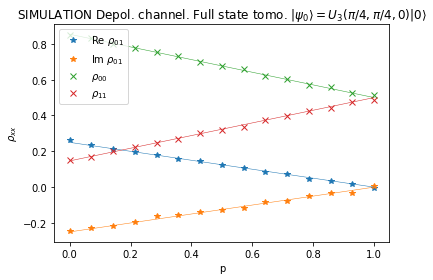

In [31]:
job = execute(tomo_circuits, backend=simulator, shots = SHOTS)

rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, p) in enumerate(p_values):
    test_result = copy.deepcopy(job.result())
    test_result.results = test_result.results[3*i:3*i+3]
    tomo_fitter = StateTomographyFitter(test_result, tomo_circuits[3*i:3*i+3])
    rhos[:,:,i] = tomo_fitter.fit()

# Simulated results
plt.plot(p_values, np.real(rhos[0,1,:]),"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(rhos[0,1,:]),"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

# Theoretical prediction

plt.plot(p_values, np.real(rho[:,0,1]), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho[:,0,1]), "C1", linewidth=.5)
plt.plot(p_values, np.real(rho[:,0,0]), "C2", linewidth=.5)
plt.plot(p_values, np.real(rho[:,1,1]), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("SIMULATION Depol. channel. Full state tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$");

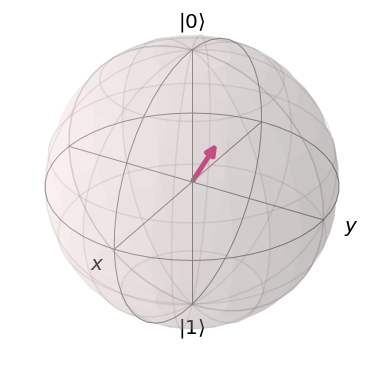

In [32]:
plot_bloch_vector(BlochVec(rhos[:,:,0]))

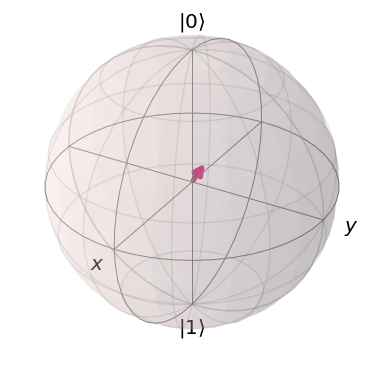

In [34]:
plot_bloch_vector(BlochVec(rhos[:,:,8]))

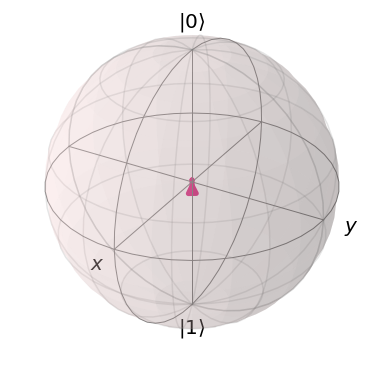

In [35]:
plot_bloch_vector(BlochVec(rhos[:,:,14]))

1. Implement Y..Y & Z..Z channels, as well as Pauli channel (*)
2. Try to follow githubs from Matteo Rossi (in the beginng of the notebook)
3. Try running these channels on real QPU's
4. Try create animations using QuTip (tutorial 2)